In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [2]:
seed = 1234
torch.manual_seed(seed)

In [3]:
torch.cuda.is_available()

True

In [22]:
data_dir = "./data"
g_dir = "./generated"
workers = 2
batch_size = 128
image_size = 64
channels = 3
latent_dim = 100
ngf = 64
ndf = 64
epochs = 100
lr = 0.0002
beta1 = 0.5
ngpu = 1

In [5]:
dataset = dset.ImageFolder(
    root=data_dir,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=workers
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

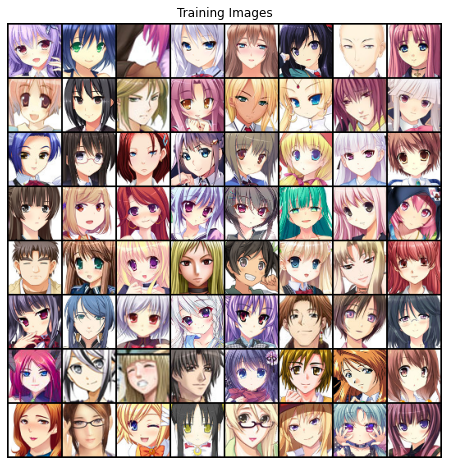

In [6]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.net(input)

In [9]:
generator = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    generator = nn.DataParallel(generator, list(range(ngpu)))

generator.apply(weights_init)

print(generator)

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.net = nn.Sequential(
            nn.Conv2d(channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.net(input)

In [11]:
discriminator = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    discriminator = nn.DataParallel(discriminator, list(range(ngpu)))

discriminator.apply(weights_init)

print(discriminator)

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [12]:
cross_entropy = nn.BCELoss()

fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

real_label = 1
fake_label = 0

d_optim = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
g_optim = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
g_img = []
g_losses = []
d_losses = []
iters = 0

for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        discriminator.zero_grad()
        
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        output = discriminator(real_cpu).view(-1)
        
        d_err_real = cross_entropy(output, label)
        
        d_err_real.backward()
        D_x = output.mean().item()

        
        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        
        fake = generator(noise)
        label.fill_(fake_label)
        
        output = discriminator(fake.detach()).view(-1)
        
        d_err_fake = cross_entropy(output, label)
        
        d_err_fake.backward()
        D_G_z1 = output.mean().item()
        
        d_err = d_err_real + d_err_fake
        
        d_optim.step()

        generator.zero_grad()
        label.fill_(real_label)  
        
        output = discriminator(fake).view(-1)
        
        g_err = cross_entropy(output, label)
        
        g_err.backward()
        D_G_z2 = output.mean().item()
        
        g_optim.step()

        if i % 50 == 0:
            print(f"epoch={epoch}/100 - [{i}/{len(dataloader)}] - Discriminator[loss={d_err.item()}] - Generator[loss={g_err.item()}]")

        g_losses.append(g_err.item())
        d_losses.append(d_err.item())

        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            g_img.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

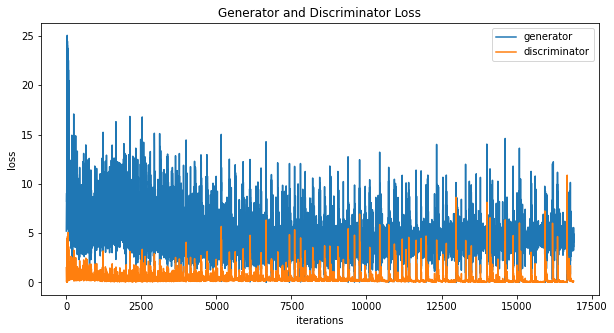

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss")
plt.plot(g_losses,label="generator")
plt.plot(d_losses,label="discriminator")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

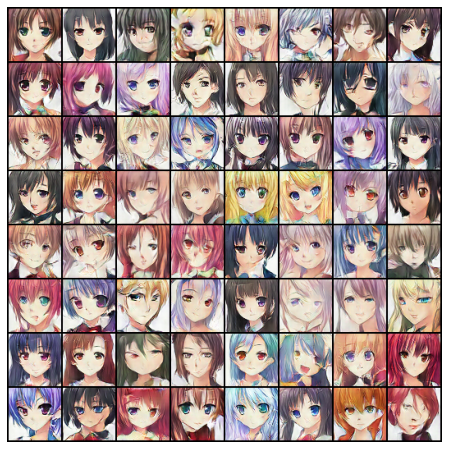

In [23]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in g_img]
plt.savefig(f"{g_dir}/generated.png")
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

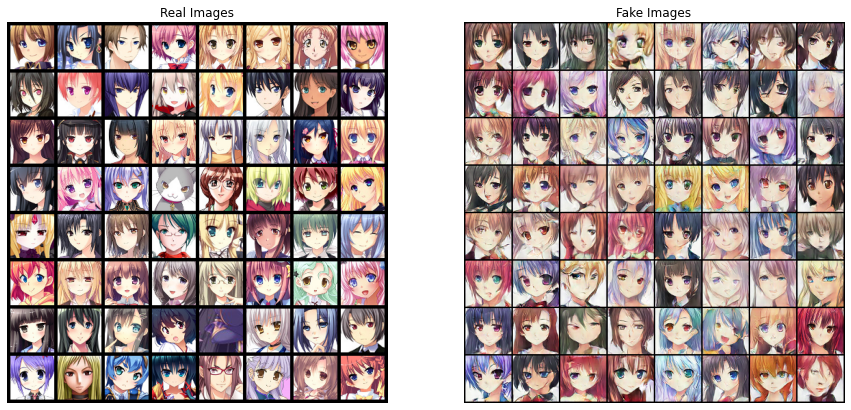

In [25]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(g_img[-1],(1,2,0)))
plt.show()

In [17]:
torch.save({
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'g_optim_state_dict': g_optim.state_dict(),
    'optimizerD_state_dict': d_optim.state_dict(),
}, "./model.pt")